##  Spark standalone master and workers

At the beginning of this lesson we saw how to create a Spark session from a notebook:

In [ ]:
# spark = SparkSession.builder \
#     .master("local[*]") \
#     .appName('test') \
#     .getOrCreate()

This code will start a local cluster, but once the notebook kernel is shut down, the cluster will disappear.

We will now see how to crate a Spark cluster in Standalone Mode so that the cluster can remain running even after we stop running our notebooks.

Simply go to your Spark install directory from a terminal (cd C:/tools/spark-3.3.2-bin-hadoop3) and run the following command:

In [ ]:
# ./sbin/start-master.sh

Unfortunately this didnt work in my windows system. So I had to run this script -

In [ ]:
# bin/spark-class.cmd org.apache.spark.deploy.master.Master --host localhost --port 7077 --webui-port 8080

You should now be able to open the main Spark dashboard by browsing to localhost:8080


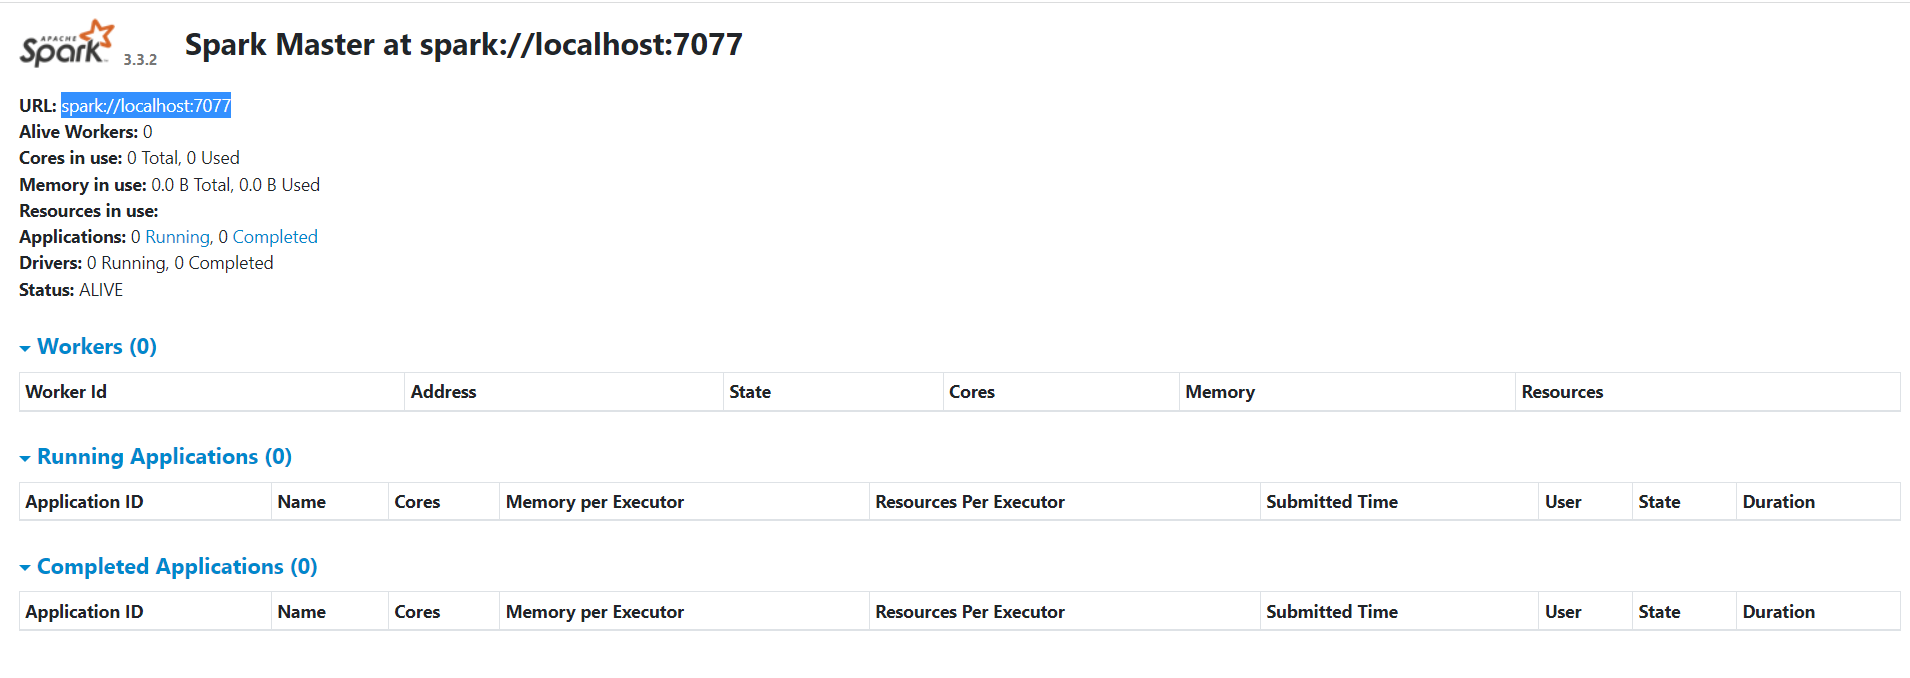

Now to start the spark session, copy the url from the dashboard (highlighted blue in the above picture) and run the following:

In [1]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("spark://localhost:7077") \
    .appName('test') \
    .getOrCreate()

In [2]:
spark

Before moving ahead, we need to configure the workers. As you can see in the above screen grab, there are currently no workers configured. Let's run the below command to configure workers

In [ ]:
# ./sbin/start-worker.sh spark://localhost:7077

Unfortunately this also didnt work in my windows system. So I had to run this script -

Notice that I gave different port and UI for the worker

In [ ]:
# bin/spark-class.cmd org.apache.spark.deploy.worker.Worker --host localhost --port 7078 --webui-port 8081 spark://localhost:7077

You should now be able to see the worker in the UI

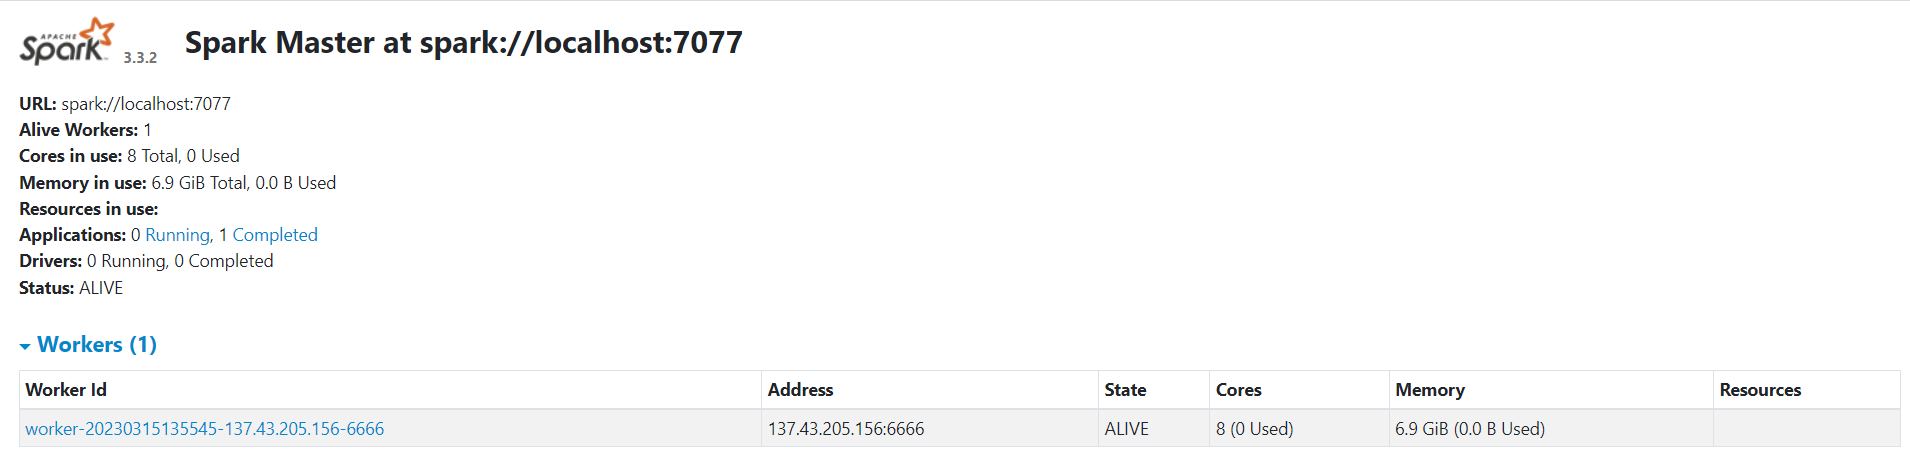

Now that the workers are set, We can run the below commands

In [3]:
df_green = spark.read.parquet("D:/data/pq/green/*/*")

In [4]:
df_green = df_green \
    .withColumnRenamed('lpep_pickup_datetime', 'pickup_datetime') \
    .withColumnRenamed('lpep_dropoff_datetime', 'dropoff_datetime')

In [5]:
df_yellow = spark.read.parquet('D:/data/pq/yellow/*/*')

In [6]:
df_yellow = df_yellow \
    .withColumnRenamed('tpep_pickup_datetime', 'pickup_datetime') \
    .withColumnRenamed('tpep_dropoff_datetime', 'dropoff_datetime')

In [7]:
common_colums = []

yellow_columns = set(df_yellow.columns)

for col in df_green.columns:
    if col in yellow_columns:
        common_colums.append(col)

In [8]:
from pyspark.sql import functions as F

In [9]:
df_green_sel = df_green \
    .select(common_colums) \
    .withColumn('service_type', F.lit('green'))

In [10]:
df_yellow_sel = df_yellow \
    .select(common_colums) \
    .withColumn('service_type', F.lit('yellow'))

In [11]:
df_trips_data = df_green_sel.unionAll(df_yellow_sel)

In [12]:
df_trips_data.groupBy('service_type').count().show()

+------------+--------+
|service_type|   count|
+------------+--------+
|       green| 2304517|
|      yellow|39649199|
+------------+--------+



In [13]:
df_trips_data.columns

['VendorID',
 'pickup_datetime',
 'dropoff_datetime',
 'store_and_fwd_flag',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'payment_type',
 'congestion_surcharge',
 'service_type']

In [14]:
df_trips_data.registerTempTable('trips_data')

C:\Users\balaj\AppData\Roaming\Python\Python39\site-packages\pyspark\sql\dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [15]:
spark.sql("""
SELECT
    service_type,
    count(1)
FROM
    trips_data
GROUP BY 
    service_type
""").show()

+------------+--------+
|service_type|count(1)|
+------------+--------+
|       green| 2304517|
|      yellow|39649199|
+------------+--------+



In [16]:
df_result = spark.sql("""
SELECT 
    -- Reveneue grouping 
    PULocationID AS revenue_zone,
    date_trunc('month', pickup_datetime) AS revenue_month, 
    service_type, 

    -- Revenue calculation 
    SUM(fare_amount) AS revenue_monthly_fare,
    SUM(extra) AS revenue_monthly_extra,
    SUM(mta_tax) AS revenue_monthly_mta_tax,
    SUM(tip_amount) AS revenue_monthly_tip_amount,
    SUM(tolls_amount) AS revenue_monthly_tolls_amount,
    SUM(improvement_surcharge) AS revenue_monthly_improvement_surcharge,
    SUM(total_amount) AS revenue_monthly_total_amount,
    SUM(congestion_surcharge) AS revenue_monthly_congestion_surcharge,

    -- Additional calculations
    AVG(passenger_count) AS avg_montly_passenger_count,
    AVG(trip_distance) AS avg_montly_trip_distance
FROM
    trips_data
GROUP BY
    1, 2, 3
""")

In [17]:
df_result.coalesce(1).write.parquet('data/report/revenue/', mode='overwrite')

## Parameterizing our scripts for Spark

Use this command to turn the notebook into a script:

In [ ]:
# jupyter nbconvert --to=script notebook_name.ipynb

Inside the .py file, add the following at the start to parameterize our script

In [ ]:
# import argparse

# import pyspark
# from pyspark.sql import SparkSession
# from pyspark.sql import functions as F

# parser.add_argument('--input_green', required=True)
# parser.add_argument('--input_yellow', required=True)
# parser.add_argument('--output', required=True)

# input_green = args.input_green
# input_yellow = args.input_yellow
# output = args.output

This will allow us to directly use these parameters in our code instead of hardcoding. For example:

In [ ]:
# df_green = spark.read.parquet(input_green)

Once we've finished our script, we simply call it from a terminal line with the parameters we need:

In [ ]:
# python notebook_name.py \
#     --input_green=D:/data/pq/green/2020/*/ \
#     --input_yellow=D:/data/pq/yellow/2020/*/ \
#     --output=D:/data/report-2020

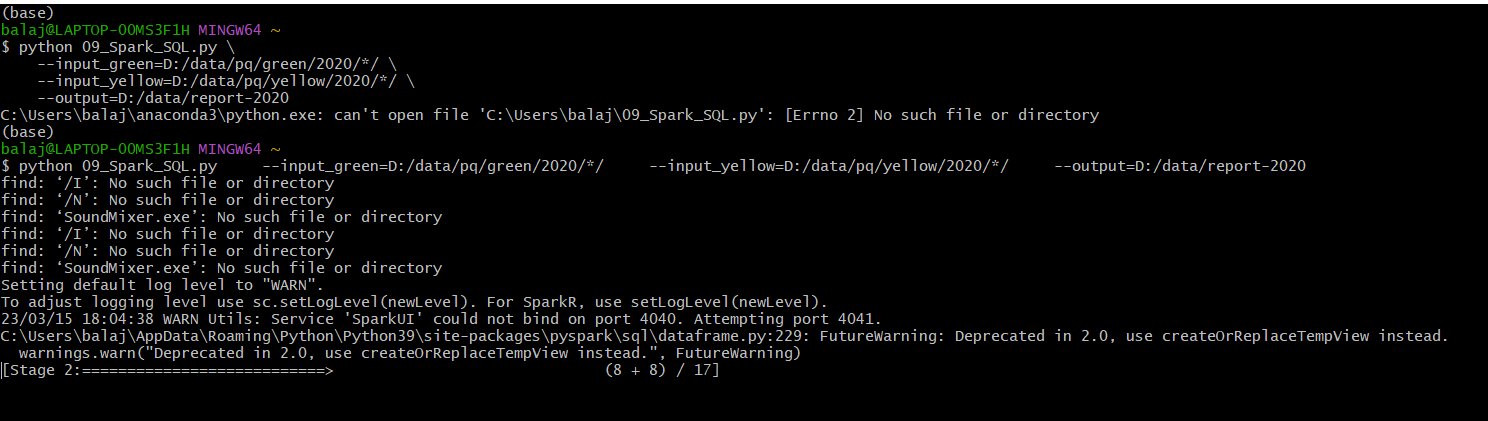

## Submitting Spark jobs with Spark submit

However, we still haven't covered any Spark specific parameters; things like the the cluster URL when having multiple available clusters or how many workers to use for the job. Instead of specifying these parameters when setting up the session inside the script, we can use an external script called Spark submit.

The basic usage is as follows:

In [ ]:
# Go to the folder where the spark files are present and then run

# bin/spark-submit.cmd \
#     --master="spark://localhost:7077" \
#     "C:\users\balaj\09_Spark_SQL.py" \
#         --input_green=D:/data/pq/green/2020/*/ \
#         --input_yellow=D:/data/pq/yellow/2020/*/ \
#         --output=D:/data/report-2020

And the Spark session code in the script is simplified:

In [ ]:
# spark = SparkSession.builder \
#     .appName('test') \
#     .getOrCreate()

After you're done running Spark in standalone mode, you will need to manually shut it down. Simply run the `./sbin/stop-worker.sh` and `./sbin/stop-master.sh` scripts to shut down Spark. 

This also didnt work for me. (There's some issue with the .sbin folder in my system I believe) So I just used Ctrl + C in the terminal to shut it down.